# SSD Trainig example.

In this notebook is the example of training procedure. Note, that it is tested only with `Tensorflow` backend and on my problem, so, **DON'T EXPECT THIS NOTEBOOK TO RUN** on your PC. It is provided only as example.

Moreover, here we see, that for my problem training data is obviously overfitted, but currently no augmentation is used. For ground truth input format, please, refer to `gt_pascal.pkl`.

In [1]:
import cv2
import keras
from keras.applications.imagenet_utils import preprocess_input
from keras.backend.tensorflow_backend import set_session
from keras.models import Model
from keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import pickle
from random import shuffle
from scipy.misc import imread, imresize
import tensorflow as tf

from ssd import SSD
from ssd_training import MultiboxLoss
from ssd_utils import BBoxUtility

%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 8)
plt.rcParams['image.interpolation'] = 'nearest'

np.set_printoptions(suppress=True)

# config = tf.ConfigProto()
# config.gpu_options.per_process_gpu_memory_fraction = 0.9
# set_session(tf.Session(config=config))

Using TensorFlow backend.


In [2]:
# some constants
NUM_CLASSES = 4
input_shape = (300, 300, 3)

In [3]:
priors = pickle.load(open('prior_boxes_ssd300.pkl', 'rb'))
bbox_util = BBoxUtility(NUM_CLASSES, priors)

In [4]:
gt = pickle.load(open('gt_pascal.pkl', 'rb'))
keys = sorted(gt.keys())
num_train = int(round(0.8 * len(keys)))
train_keys = keys[:num_train]
val_keys = keys[num_train:]
num_val = len(val_keys)

In [5]:
batch_size = 8
path_prefix = '../../frames/'

def generator(keys):
    while True:
        shuffle(keys)
        inputs = []
        targets = []
        for key in keys:            
            img_path = path_prefix + key
            img = image.load_img(img_path,
                                 target_size=(input_shape[0],
                                              input_shape[1]))
            img = image.img_to_array(img)
            inputs.append(img)
            y = bbox_util.assign_boxes(gt[key])
            targets.append(y)
            if len(targets) == batch_size:
                tmp_inp = np.array(inputs)
                tmp_targets = np.array(targets)
                inputs = []
                targets = []
                yield preprocess_input(tmp_inp), tmp_targets

In [6]:
model = SSD(input_shape, num_classes=NUM_CLASSES)
model.load_weights('weights_300x300.hdf5', by_name=True)

In [7]:
def schedule(epoch, decay=0.9):
    return base_lr * decay**(epoch)

callbacks = [keras.callbacks.ModelCheckpoint('./checkpoints/weights.{epoch:02d}-{val_loss:.2f}.hdf5',
                                             verbose=1,
                                             save_weights_only=True),
             keras.callbacks.LearningRateScheduler(schedule)]

In [8]:
base_lr = 1e-3
optim = keras.optimizers.Adam(lr=base_lr)
# optim = keras.optimizers.RMSprop(lr=base_lr)
# optim = keras.optimizers.SGD(lr=base_lr, momentum=0.9, decay=decay, nesterov=True)
model.compile(optimizer=optim,
              loss=MultiboxLoss(NUM_CLASSES).compute_loss)

In [9]:
nb_epoch = 30
history = model.fit_generator(generator(train_keys), num_train // batch_size,
                              nb_epoch, verbose=1,
                              callbacks=callbacks,
                              validation_data=generator(val_keys),
                              nb_val_samples=num_val // batch_size,
                              nb_worker=1)

/root/anaconda3/lib/python3.5/site-packages/tensorflow/python/ops/gradients.py:90: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
576/581 [============================>.] - ETA: 0s - loss: 3.6230

/root/anaconda3/lib/python3.5/site-packages/keras/engine/training.py:1480: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


Epoch 00000: saving model to ./checkpoints/weights.00-3.33.hdf5
584/581 [==============================] - 78s - loss: 3.6238 - val_loss: 3.3322
Epoch 2/30
584/581 [==============================] - 68s - loss: 2.8665 - val_loss: 2.9508
Epoch 3/30
584/581 [==============================] - 72s - loss: 2.7508 - val_loss: 2.9436
Epoch 4/30
584/581 [==============================] - 72s - loss: 2.4341 - val_loss: 2.3877
Epoch 5/30
584/581 [==============================] - 72s - loss: 1.9656 - val_loss: 2.3824
Epoch 6/30
584/581 [==============================] - 72s - loss: 1.6400 - val_loss: 2.4913
Epoch 7/30
584/581 [==============================] - 72s - loss: 1.4062 - val_loss: 2.2254
Epoch 8/30
584/581 [==============================] - 72s - loss: 1.2052 - val_loss: 2.5189
Epoch 9/30
584/581 [==============================] - 72s - loss: 1.0136 - val_loss: 2.1413
Epoch 10/30
584/581 [==============================] - 72s - loss: 0.8311 - val_loss: 2.3656
Epoch 11/30
584/581 [=====

In [16]:
inputs = []
images = []
img_path = path_prefix + train_keys[888]
img = image.load_img(img_path, target_size=(300, 300))
img = image.img_to_array(img)
images.append(imread(img_path))
inputs.append(img.copy())
inputs = preprocess_input(np.array(inputs))

In [17]:
preds = model.predict(inputs, batch_size=1, verbose=1)
results = bbox_util.detection_out(preds)

1/1 [==============================] - 0s


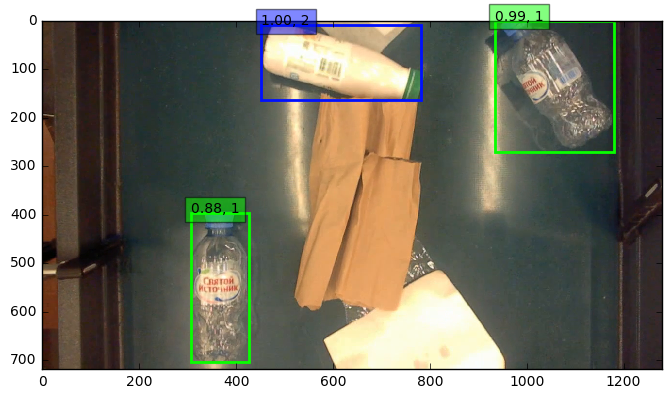

In [18]:
for i, img in enumerate(images):
    # Parse the outputs.
    det_label = results[i][:, 0]
    det_conf = results[i][:, 1]
    det_xmin = results[i][:, 2]
    det_ymin = results[i][:, 3]
    det_xmax = results[i][:, 4]
    det_ymax = results[i][:, 5]

    # Get detections with confidence higher than 0.6.
    top_indices = [i for i, conf in enumerate(det_conf) if conf >= 0.6]

    top_conf = det_conf[top_indices]
    top_label_indices = det_label[top_indices].tolist()
    top_xmin = det_xmin[top_indices]
    top_ymin = det_ymin[top_indices]
    top_xmax = det_xmax[top_indices]
    top_ymax = det_ymax[top_indices]

    colors = plt.cm.hsv(np.linspace(0, 1, 4)).tolist()

    plt.imshow(img / 255.)
    currentAxis = plt.gca()

    for i in range(top_conf.shape[0]):
        xmin = int(round(top_xmin[i] * img.shape[1]))
        ymin = int(round(top_ymin[i] * img.shape[0]))
        xmax = int(round(top_xmax[i] * img.shape[1]))
        ymax = int(round(top_ymax[i] * img.shape[0]))
        score = top_conf[i]
        label = int(top_label_indices[i])
#         label_name = voc_classes[label - 1]
        display_txt = '{:0.2f}, {}'.format(score, label)
        coords = (xmin, ymin), xmax-xmin+1, ymax-ymin+1
        color = colors[label]
        currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
        currentAxis.text(xmin, ymin, display_txt, bbox={'facecolor':color, 'alpha':0.5})
    
    plt.show()